This notebook is based off of Fatima's `peak_fit_trend_SFR.ipynb` notebook and is designed to compute and plot the $M_*$ as a function of depth inside the V$^2$ voids.

This analysis requires binning the V$^2$ galaxies by their normalized depth inside a void and fitting the resulting distirbution in $M_*$.  We then compute the ratio of the means of the two skew normal distributions at each depth value.

In [1]:
import numpy as np

from astropy.table import Table
from astropy.io import fits

from scipy.optimize import curve_fit, minimize_scalar
from scipy.stats import skewnorm

from functions import model_skew, estimate_Jacobian, depth_plot

import matplotlib.pyplot as plt
%matplotlib inline

# Data

In [2]:
filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdul = fits.open(filename)
data = Table(hdul[1].data)
hdul.close()

## Just keep the main SDSS DR7 footprint

In [3]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [4]:
# Also only keep those within the redshift limit of the void catalogs
vollim = catalog_main[catalog_main['Z'] <= 0.114]

## Separate galaxies by their LSS classifications

### $V^2$

In [5]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [6]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# $M_*$ as a function of void depth

Bin the V$^2$ void galaxies by how far from their void boundary they are, and plot the location of the $M_*$ peak in that bin as a function of the distance from the void boundary.  The plot will be cumulative from the inside of a void out, so we are really trying to find the "true" void galaxy population using V$^2$.

In [22]:
def func_unimodal(x, a, mu, sg, skew):
    """
    One skew normal distribution
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a : float
        amplitude of the skew normal distribution
        
    mua : float
        location of the skew normal distribution
        
    sg : float
        width of the skew normal distribution
        
    skew : float
        skew of the skew normal distribution
    

    Returns
    -------
    model : float or ndarray
        Model evaluated at x.
    """

    return a*skewnorm.pdf(x, skew, loc=mu, scale=sg)


def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    """
    Mixture of two skew normal distributions.
    

    Parameters
    ----------

    x : float or ndarray
        Values to calculate the model.
        
    a, b : float
        amplitudes of the skew normal distributions
        
    mua, mub : float
        locations of the skew normal distributions
        
    sga, sgb : float
        widths of the skew normal distributions
        
    askew, bskew : float
        skews of the skew normal distributions
    

    Returns
    -------
    model : float or ndarray
        Mixture model evaluated at x.
    """

    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + \
           b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)

In [8]:
def bin_data(data, bins_, label="label me", plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)

    dn1 = np.sqrt(n1)

    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title(label)
        plt.show()
        
    return  x, n1, dn1 #, popt_void

In [26]:
def fit_unimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = dy
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, model_skew(popt_, x_data), 'k')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_


def fit_bimodal(char_, bins, class_=None, p0_=None, err=None, label=''):
    
    if class_ is None:
        x_data, y_data, dy = bin_data(data=char_, bins_=bins)
    else:
        x_data, y_data, dy = bin_data(data=char_[class_], bins_=bins)   
    
    if err is None:
        err = dy
    else:
        err[np.argwhere(err==0)] = 0.00001
    
    popt_, pcov_ = curve_fit(func_bimodal, x_data, y_data, p0=p0_)#, sigma=s)#, sigma=cov)
    
    ############################################################################
    # Plot distribution and best fit
    #---------------------------------------------------------------------------
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_bimodal(x_data, *popt_), 'k')
    plt.plot(x_data, model_skew(popt_[:4], x_data), 'r')
    plt.plot(x_data, model_skew(popt_[4:], x_data), 'b')
    plt.ylabel('Counts')
    plt.title(label)
    plt.show()
    ############################################################################
    
    print(popt_, np.sqrt(np.diag(pcov_)))
    
    #return popt_, np.sqrt(np.diag(pcov_))
    return popt_, pcov_

# How does the location of the maximum in the $M_*$ distribution depend on depth in the V$^2$ voids?

In [10]:
Mstar_bins = np.arange(7.5, 11.5, 0.1)

## Full sample

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/669798741.py:1: RuntimeWarning: divide by zero encountered in log10
  Mstar_all_fit_uni = fit_unimodal(char_=np.log10(vollim['ELPETRO_MASS']),


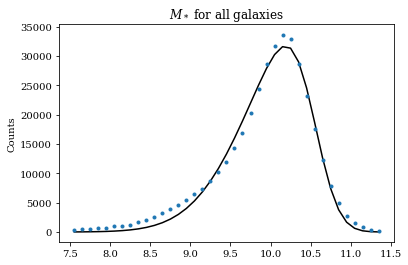

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/669798741.py:6: RuntimeWarning: divide by zero encountered in log10
  Mstar_all_fit_bi = fit_bimodal(char_=np.log10(vollim['ELPETRO_MASS']),


[ 3.60725194e+04  1.05418800e+01  7.49228662e-01 -3.01378793e+00] [5.92142279e+02 1.29635283e-02 2.14385610e-02 2.82844276e-01]


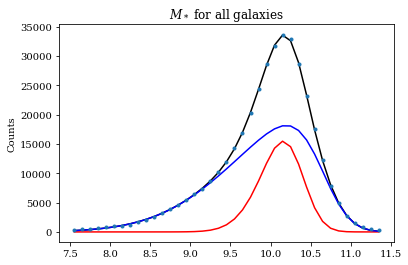

[ 1.04855560e+04  1.03650550e+01  3.80155422e-01 -1.64877704e+00
  2.71733354e+04  1.06436176e+01  1.02624127e+00 -3.66427283e+00] [4.88155230e+02 8.18681923e-03 1.20108631e-02 1.61855980e-01
 4.68702571e+02 1.41265869e-02 1.44314902e-02 2.08698304e-01]


In [27]:
Mstar_all_fit_uni = fit_unimodal(char_=np.log10(vollim['ELPETRO_MASS']),
                                 bins=Mstar_bins, 
                                 p0_=[20000, 10, 0.75, -2.25], 
                                 label=r'$M_*$ for all galaxies')

Mstar_all_fit_bi = fit_bimodal(char_=np.log10(vollim['ELPETRO_MASS']),
                               bins=Mstar_bins, 
                               p0_=[20000, 10, 0.75, -2.25, 20000, 10, 0.75, -2.25], 
                               label=r'$M_*$ for all galaxies')

In [28]:
all_uni = minimize_scalar(lambda x: -func_unimodal(x, *Mstar_all_fit_uni[0]), bounds=(9,11), method='bounded')
all_bi = minimize_scalar(lambda x: -func_bimodal(x, *Mstar_all_fit_bi[0]), bounds=(9,11), method='bounded')

Mstar_max_all_uni = all_uni.x
Mstar_max_all_bi = all_bi.x

print(Mstar_max_all_uni, Mstar_max_all_bi)

10.187823736955915 10.16719896926398


## VoidFinder void

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/817630791.py:1: RuntimeWarning: divide by zero encountered in log10
  Mstar_VF_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


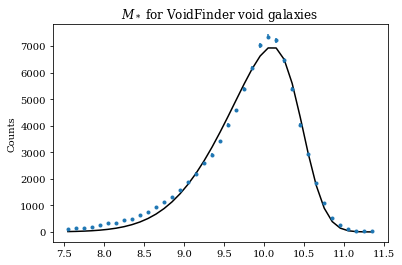

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/817630791.py:7: RuntimeWarning: divide by zero encountered in log10
  Mstar_VF_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


[ 8.36811861e+03  1.04653328e+01  8.11012479e-01 -3.41037915e+00] [1.16153744e+02 1.04983681e-02 1.85031205e-02 2.65361410e-01]


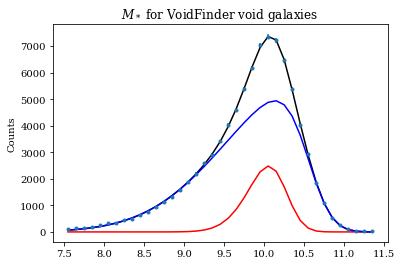

[ 1.53333439e+03  1.02492361e+01  3.58812678e-01 -1.86308021e+00
  7.08798674e+03  1.05439383e+01  1.00735879e+00 -4.20447816e+00] [1.04508158e+02 1.01443292e-02 1.67494906e-02 2.46568782e-01
 1.00076020e+02 9.12691439e-03 1.27766060e-02 1.88254319e-01]


In [29]:
Mstar_VF_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),
                                class_=void_vf,
                                bins=Mstar_bins, 
                                p0_=[20000, 10, 0.75, -2.25], 
                                label=r'$M_*$ for VoidFinder void galaxies')

Mstar_VF_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),
                              class_=void_vf,
                              bins=Mstar_bins, 
                              p0_=[20000, 10, 0.75, -2.25, 20000, 10, 0.75, -2.25], 
                              label=r'$M_*$ for VoidFinder void galaxies')

In [30]:
VF_uni = minimize_scalar(lambda x: -func_unimodal(x, *Mstar_VF_fit_uni[0]), bounds=(9,11), method='bounded')
VF_bi = minimize_scalar(lambda x: -func_bimodal(x, *Mstar_VF_fit_bi[0]), bounds=(9,11), method='bounded')

Mstar_max_VF_uni = VF_uni.x
Mstar_max_VF_bi = VF_bi.x

print(Mstar_max_VF_uni, Mstar_max_VF_bi)

10.101070350033568 10.078552751880665


## V$^2$ voids

6380


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


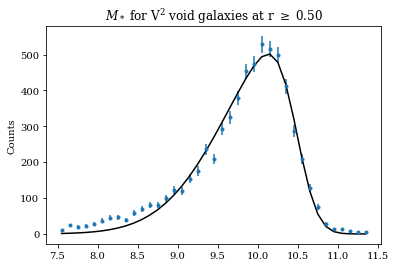

[602.95940663  10.48066583   0.83546627  -3.96335533] [11.63046041  0.01318296  0.02494131  0.42627238]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


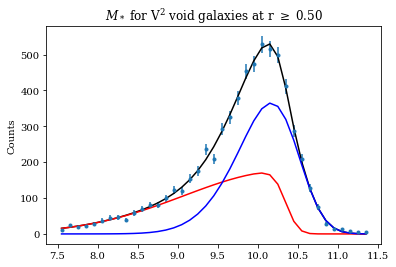

[279.67454531  10.34835455   1.27029543 -10.50380593 358.29612693
  10.47685095   0.58878724  -2.08002296] [4.13397707e+01 4.17619678e-02 1.08516923e-01 3.20180937e+00
 4.31872980e+01 2.76187861e-02 4.76656832e-02 4.45462180e-01]
12636


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


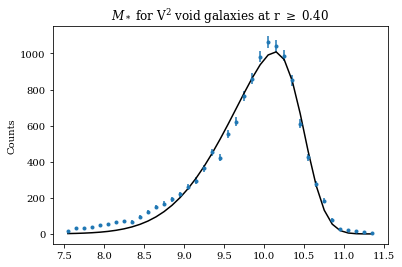

[ 1.20404431e+03  1.04887344e+01  8.19629931e-01 -3.71450449e+00] [2.09535647e+01 1.23199340e-02 2.26235334e-02 3.60466033e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


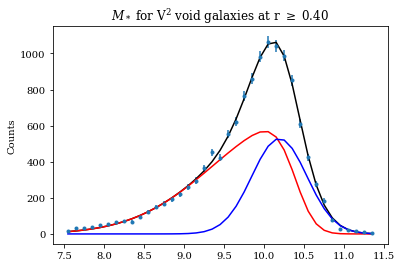

[ 7.99024595e+02  1.03830012e+01  1.01385481e+00 -5.04294013e+00
  4.54793851e+02  1.01881968e+01  3.43493743e-01  7.04068520e-03] [5.43388425e+01 4.26495721e-02 3.61146546e-02 7.15984298e-01
 5.60305137e+01 1.26928495e+03 7.12919147e+00 4.63150777e+03]
20721


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


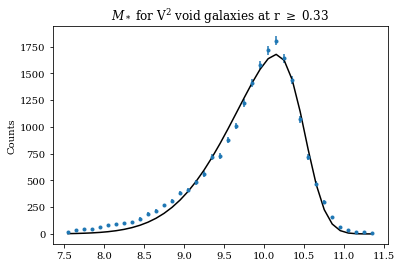

[ 1.97879408e+03  1.04984599e+01  8.12652968e-01 -3.75627886e+00] [3.22282128e+01 1.13226006e-02 2.09005569e-02 3.41062766e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


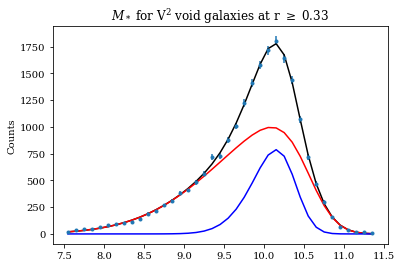

[ 1.51880268e+03  1.05432917e+01  1.04700636e+00 -3.70472612e+00
  5.40296054e+02  1.03662352e+01  4.11694942e-01 -2.08006718e+00] [7.32935733e+01 4.49014516e-02 3.40598022e-02 6.28312738e-01
 7.56036908e+01 2.55556114e-02 2.83599729e-02 4.04377395e-01]
31104


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


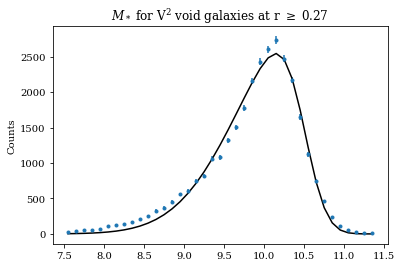

[ 2.97889322e+03  1.04995583e+01  7.99325974e-01 -3.58912724e+00] [4.86145106e+01 1.16116885e-02 2.09785177e-02 3.27054378e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


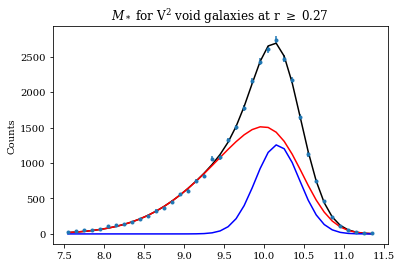

[ 2.21870295e+03  1.04428842e+01  9.57864840e-01 -2.91312271e+00
  8.66878398e+02  1.01671418e+01  2.74957839e-01 -2.47432149e-03] [5.65662822e+02 2.18093859e-01 6.53885514e-02 1.41401368e+00
 5.68197894e+02 7.06646614e+02 1.47399574e+00 3.22096348e+03]
44538


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


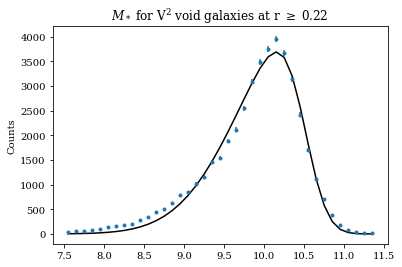

[ 4.27246876e+03  1.05040264e+01  7.84777935e-01 -3.45388712e+00] [6.79950994e+01 1.15106304e-02 2.04139367e-02 3.07781183e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


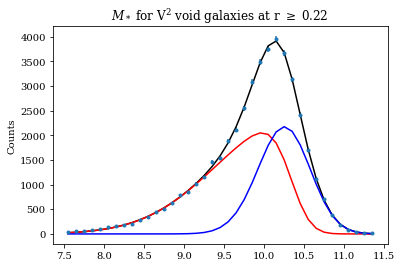

[ 2.64847102e+03  1.03300588e+01  9.22302666e-01 -4.67816623e+00
  1.77800417e+03  1.04284681e+01  3.78080670e-01 -8.03487345e-01] [1.52796770e+02 3.62907511e-02 2.08930187e-02 5.38573356e-01
 1.51570583e+02 9.83138748e-02 5.89750184e-02 5.52028798e-01]
62095


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


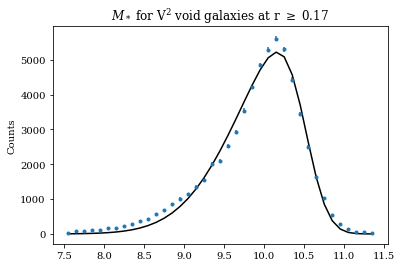

[ 5.95318064e+03  1.05083430e+01  7.67918117e-01 -3.35513352e+00] [9.65306320e+01 1.17920474e-02 2.06146721e-02 3.05498145e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


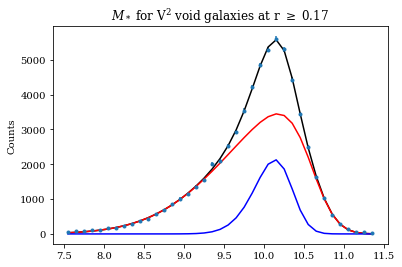

[ 4.88825300e+03  1.05847761e+01  9.81342676e-01 -3.87977376e+00
  1.28549022e+03  1.03225170e+01  3.49728915e-01 -1.85083036e+00] [1.00866382e+02 1.51371791e-02 1.83515964e-02 2.78911738e-01
 1.05327888e+02 1.24890993e-02 1.99725274e-02 3.04092585e-01]
85110


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


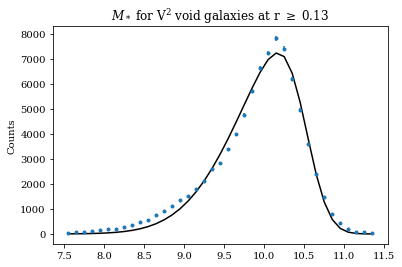

[ 8.15907526e+03  1.05158873e+01  7.55568450e-01 -3.26845946e+00] [1.33312080e+02 1.19878249e-02 2.06836834e-02 3.00907121e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


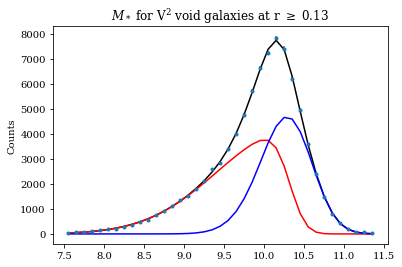

[ 4.63601237e+03  1.03164596e+01  9.02380942e-01 -5.67595151e+00
  3.82884712e+03  1.05094233e+01  4.20872288e-01 -1.22968002e+00] [1.42606174e+02 1.31095546e-02 1.67653853e-02 4.50376503e-01
 1.44656904e+02 2.20242287e-02 2.45249733e-02 1.97014267e-01]
115628


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


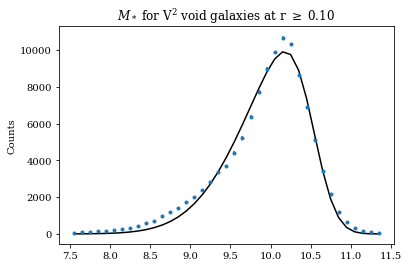

[ 1.10760023e+04  1.05229240e+01  7.41102722e-01 -3.14906875e+00] [1.86766889e+02 1.25908222e-02 2.13113067e-02 3.00936769e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


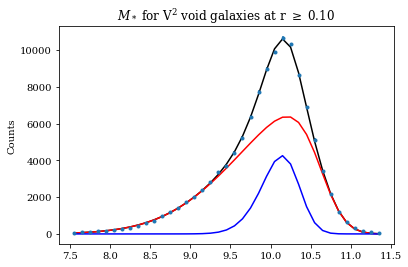

[ 8.96675153e+03  1.06158969e+01  9.72754964e-01 -3.89671522e+00
  2.54350858e+03  1.03284553e+01  3.41003059e-01 -1.75480082e+00] [1.83576816e+02 1.41713992e-02 1.85283781e-02 2.65365792e-01
 1.91656992e+02 1.17015594e-02 1.88826943e-02 2.79560750e-01]
156341


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


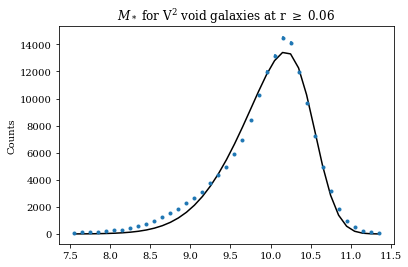

[ 1.49777758e+04  1.05340470e+01  7.35835316e-01 -3.07259739e+00] [2.52450330e+02 1.28123605e-02 2.14084579e-02 2.94880324e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


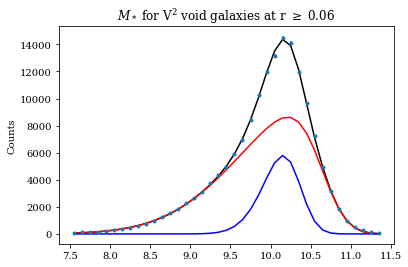

[ 1.21065610e+04  1.06287369e+01  9.66370382e-01 -3.76883045e+00
  3.46151957e+03  1.03418381e+01  3.42652677e-01 -1.78047587e+00] [2.57077779e+02 1.47557674e-02 1.92571835e-02 2.60894543e-01
 2.68334617e+02 1.16602960e-02 1.93096230e-02 2.81118465e-01]
205744


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


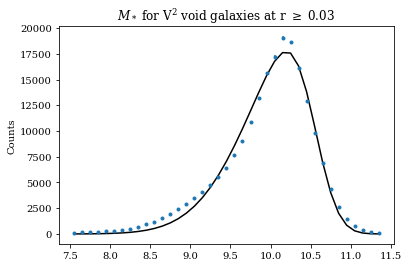

[ 1.97194906e+04  1.05429417e+01  7.33418171e-01 -3.03015865e+00] [3.29558698e+02 1.28471618e-02 2.13071911e-02 2.89167033e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


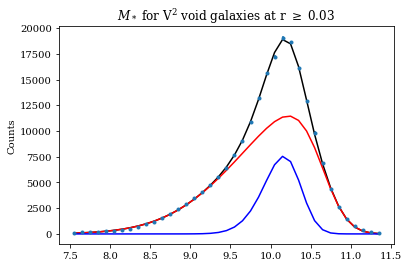

[ 1.60067924e+04  1.06377861e+01  9.59674857e-01 -3.70282241e+00
  4.48087324e+03  1.03494037e+01  3.40769001e-01 -1.78704861e+00] [3.01107227e+02 1.30461813e-02 1.71415878e-02 2.24833976e-01
 3.14225994e+02 1.03773948e-02 1.74208628e-02 2.52152579e-01]
247281


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:30: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


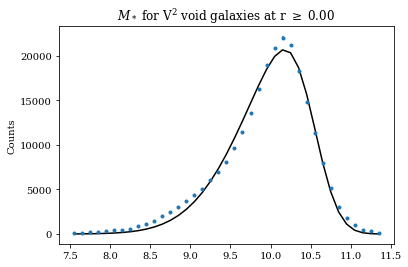

[ 2.38306331e+04  1.05331255e+01  7.53804344e-01 -2.95148992e+00] [3.58172954e+02 1.22110403e-02 1.99653462e-02 2.54831612e-01]


/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_91891/4139504748.py:35: RuntimeWarning: divide by zero encountered in log10
  Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']),


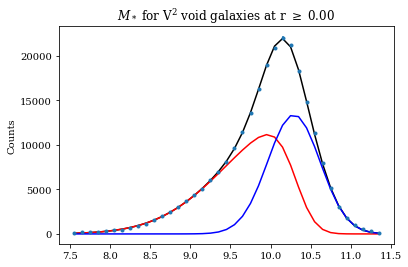

[ 1.36156084e+04  1.03079030e+01  8.59901986e-01 -4.30059074e+00
  1.10122611e+04  1.02880589e+01  3.27970678e-01  1.27919413e-02] [2.29856262e+02 1.41817355e-02 1.08384754e-02 2.70299844e-01
 2.25893957e+02 1.32341978e+02 1.34804621e+00 5.05821219e+02]


In [33]:
# Number of slices
N = 10

# Volume of inner-most slice (r = 0.5)
r_in = 0.5
V_in = r_in**3 # Normalized by 4/3*pi, since this is the volume of the entire volume

# volume-spacing
d_vol = (4./3.)*np.pi*(1 - V_in)/N

# Initialize variable that will store the previous radius value
r_limits = np.zeros(N+1, dtype=float)
r_limits[0] = r_in

# Initialize arrays that will store the maxima
Mstar_max_V2_uni = -1*np.ones(N+1, dtype=float)
Mstar_max_V2_bi = -1*np.ones(N+1, dtype=float)

for i in range(N + 1):
    
    # Calculate minimum radius of this slice
    if i != 0:
        r_limits[i] = 1 - ((1 - r_limits[i - 1])**3 + (3*d_vol/(4*np.pi)))**(1./3.)
    
    # Select all V2 void galaxies with normalized void depths greater than or equal to this value
    gals_in = (catalog_main['V2_depth'] >= r_limits[i]) & void_v2
    print(np.sum(gals_in))
    
    # Fit this distribution
    Mstar_V2slice_fit_uni = fit_unimodal(char_=np.log10(catalog_main['ELPETRO_MASS']), 
                                         class_=gals_in, 
                                         bins=Mstar_bins, 
                                         p0_=[2000, 10, 0.75, -2.25], 
                                         label=r'$M_*$ for V$^2$ void galaxies at r $\geq$ {:.2f}'.format(r_limits[i]))
    Mstar_V2slice_fit_bi = fit_bimodal(char_=np.log10(catalog_main['ELPETRO_MASS']), 
                                       class_=gals_in, 
                                       bins=Mstar_bins, 
                                       p0_=[1000, 10, 1, -2, 1000, 10, 0.5, -1.5], 
                                       label=r'$M_*$ for V$^2$ void galaxies at r $\geq$ {:.2f}'.format(r_limits[i]))
    
    # Calculate local maxima
    V2_uni = minimize_scalar(lambda x: -func_unimodal(x, *Mstar_V2slice_fit_uni[0]), 
                             bounds=(9,11), 
                             method='bounded')
    V2_bi = minimize_scalar(lambda x: -func_bimodal(x, *Mstar_V2slice_fit_bi[0]), 
                             bounds=(9,11), 
                             method='bounded')
    
    # Save maximum location
    Mstar_max_V2_uni[i] = V2_uni.x
    Mstar_max_V2_bi[i] = V2_bi.x

## Plot results

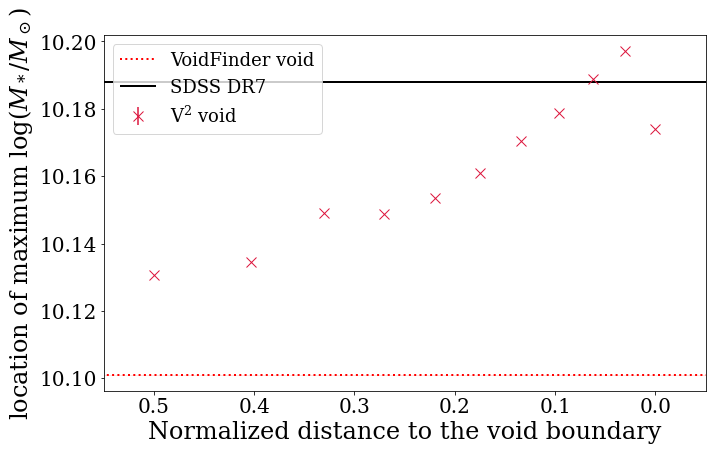

In [34]:
depth_plot(Mstar_max_VF_uni, 0., 
           Mstar_max_all_uni, 0., 
           Mstar_max_V2_uni, np.zeros(len(Mstar_max_V2_uni)), 
           r_limits, 
           y_label='location of maximum log($M_*/M_\odot$)', 
           #filename='sSFR_depth'
           )

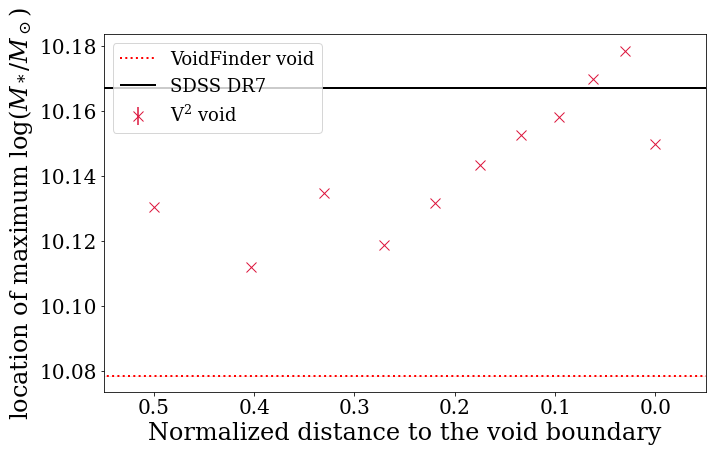

In [35]:
depth_plot(Mstar_max_VF_bi, 0., 
           Mstar_max_all_bi, 0., 
           Mstar_max_V2_bi, np.zeros(len(Mstar_max_V2_bi)), 
           r_limits, 
           y_label='location of maximum log($M_*/M_\odot$)', 
           #filename='sSFR_depth'
           )